In [ ]:
#@title 
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/computer-vision-um/cv-um-2023/trabajo-final/


# Ejercicio 2.1: Face Detection

Tal como se explica en la letra del obligatorio final en este ejercicio es necesario implementar desde cero una solucion para detección de caras. Se proveen datos de entrenamiento y es necesario implementar su propio algoritmo de sliding window para entrenar un clasificador. Todo el código necesario para comenzar a trabajar está provisto en este notebook.


\**En los ejercicios del trabajo final es posible utilizar funciones de librerias existentes o código sacado de internet. Siempre y cuando **no se usen para resolver explicitamente lo que pide el ejercicio** y al código sacado de interenet le agreguen el link en comentarios de donde fue sacado ese código.*

**Es necesario implemntar su propio algoritmo de sliding window**



##### Imports necesarios

In [6]:
import cv2 
import numpy as np
from glob import glob
from enum import Enum
import os
import sklearn 
import sklearn.neighbors
import matplotlib.pyplot as plt
import pickle
from evaluation import evaluate_detector, precision_and_recall, interpolated_average_precision
import sys
from image_utils import non_max_suppression
from tqdm import tqdm
import pandas as pd
from typing import Tuple

### Funciones Provistas

#### Feature Extractors 

Para resolver el ejercicio van a tener que implementar las funciones `extract_hog_features` y `extract_lbp_features` pueden utilizar librerias como `skimage` o implementar ustedes mismos los descriptores. 

In [3]:
class FeatureExtractors(Enum):
		MiniImage = 1
		HOG = 2
		LBP = 3

def extract_features(method:Enum, image:np.ndarray) -> np.ndarray:
	'''Switch between Feature extraction Methods'''

	image_representation = []

	if method == FeatureExtractors.MiniImage:
		image_representation = extract_mini_image_features(image)
	elif method == FeatureExtractors.HOG:
		image_representation = extract_hog_features(image)
	elif method == FeatureExtractors.LBP:
		image_representation = extract_lbp_features(image)	
	
	return image_representation

def extract_mini_image_features(image:np.ndarray,resize_size=(64,64)) -> np.ndarray:
    shape = image.shape
    if len(shape) > 2:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(image,resize_size)
    image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
    return image_representation
  
def extract_lbp_features(image:np.ndarray) -> np.ndarray:
  return np.array()

def extract_hog_features(imgage:np.ndarray)-> np.ndarray:
  return np.array()

#### Data loader


In [26]:
def load_training_data(training_positive_dir:str,trainign_negative_dir:str,feature_extractor=FeatureExtractors.MiniImage,target_size=[64,64], n_samples=2500) -> Tuple[np.ndarray,np.ndarray]:
    ''' Function for loading loading training data from positive and negative examples
    '''
    positive_img_files = sorted(glob(training_positive_dir + '/*'))
    negative_img_files = sorted(glob(trainign_negative_dir + '/*'))
    #comment this line for loading all data
    positive_img_files = positive_img_files[:n_samples]
    negative_img_files = negative_img_files[:n_samples]
    training_data = []
    training_labels = []
    
    print('##Loading {} positive face images'.format(len(positive_img_files)))
    for img in tqdm(positive_img_files, total=len(positive_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(1)
    
    print('##Loading {} negative face images'.format(len(negative_img_files)))
    for img in tqdm(negative_img_files,total=len(negative_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(0)   
    
    training_data = np.asarray(training_data)
    training_labels = np.asarray(training_labels)
    return training_data, training_labels

def load_validation_data(validation_data_dir:str)-> Tuple[np.ndarray,np.ndarray]:

    validation_image_files = sorted(glob(validation_data_dir + '/*.jpg'))
    validation_images = []
    validation_annotations= pd.read_pickle(os.path.join(validation_data_dir,'validation_bbox.pickle'))
    print(validation_annotations.shape)
    validation_bboxes = []
    for img_file in tqdm(validation_image_files,total=len(validation_image_files)):
        image = cv2.imread(img_file,cv2.IMREAD_COLOR)
        height,width,_ = image.shape
        validation_images.append(image)
        image_name = os.path.basename(img_file)
        bbox_info = validation_annotations.loc[validation_annotations["image_id"]==image_name]
        bbox = np.array([int(bbox_info['x_left'].values[0]*width),
                         int(bbox_info['y_top'].values[0]*height),
                         int((bbox_info['x_left'].values[0]+bbox_info['width'].values[0])*width),
                         int((bbox_info['y_top'].values[0]+bbox_info['height'].values[0])*height)])
        validation_bboxes.append(bbox)
        
    return validation_images, validation_bboxes

#### Sliding Window


In [27]:
def sliding_window(image, window_size, scale, stride):
    [image_rows, image_cols] = image.shape;
    window_rows = window_size[0];
    window_cols = window_size[1];

    patches = np.zeros((window_rows, window_cols,5));
    bbox_locations = np.zeros((5,4))
    r = np.random.randint(0,image_rows-window_rows,5); # Sample top left position
    c = np.random.randint(0,image_cols-window_cols,5);
    for i in range(0,5):
        patches[:,:,i] = image[r[i]:r[i]+window_rows, c[i]:c[i]+window_cols];
        bbox_locations[i,:] = [r[i],c[i],window_rows,window_cols]; # top-left y,x, height, width


    return patches, bbox_locations

##### Metodos Auxiliares

In [28]:
def show_image_with_bbox(image,bboxes,gt_bbox,draw_GT=True):
    if draw_GT: 
        cv2.rectangle(image, (gt_bbox[0],gt_bbox[1]), (gt_bbox[2],gt_bbox[3]), (0, 0, 255), 2)

    for bbox in bboxes:
        if len(bbox) == 4:   
            top_left = (int(bbox[0]),int(bbox[1]))
            bottom_right = (int(bbox[0])+ int(bbox[2]),int(bbox[1])+int(bbox[3]))
            cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)

    plt.imshow(image[...,::-1])
    plt.axis('off')
    plt.show()

### Ubicación de los datos ###

In [29]:
DATA_DIR ='./'
FACE_DETECTION_DIR = os.path.join(DATA_DIR, 'face_detection')
TRAINING_FACES_DIR = os.path.join(FACE_DETECTION_DIR,'cropped_faces')
NEGATIVE_EXAMPLES_DIR = os.path.join(FACE_DETECTION_DIR,'negative_data')
VALIDATION_FACES_DIR = os.path.join(FACE_DETECTION_DIR,'validation')

## Entrenar Modelo y Face Detection


### Cargar Datos de Entrenamiento ###

In [30]:
#Modify data_loader.py to load more training data
training_data, trainig_labels = load_training_data(TRAINING_FACES_DIR,NEGATIVE_EXAMPLES_DIR, FeatureExtractors.MiniImage)
# You can save traninig_data and labels on nunmpy files to avoid processing data every time. 

##Loading 2500 positive face images


100%|█████████████████████████████████████| 2500/2500 [00:02<00:00, 1219.21it/s]


##Loading 2500 negative face images


100%|█████████████████████████████████████| 2500/2500 [00:01<00:00, 1604.20it/s]


### Load Validation Data ###


In [31]:
validation_data = load_validation_data(VALIDATION_FACES_DIR)

(877, 5)


100%|████████████████████████████████████████| 877/877 [00:01<00:00, 704.45it/s]


### Entrenar un clasificador utilizando los datos de entrenamiento ## 
1. Una vez los datos de entrenamiento han sido cargados es necesario entrenar su propio clasificador 
2. Como solución inicial se utiliza un clasificador KNN pero para tener mejores resultados es posible entrenar un SVM. Se puede utilizar el [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) de sklearn a modo de ejemplo. Tambiés es posible utilizar la libreria [liblinear](https://pypi.org/project/liblinear-official/)
3. Entrenar su clasificador y guardarlo en el archivo `face_detector`

In [32]:
knn_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)

In [33]:
knn_classifier.fit(training_data,trainig_labels)

KNeighborsClassifier(n_neighbors=3)

#### Guardar el modelo entrenado ##


In [34]:
pickle.dump(knn_classifier,open('./face_detector', 'wb'))

#### Cargar el Modelo entrenado 

In [35]:
classifier = pickle.load(open('./face_detector','rb'))

### Sliding Window y Resultados ###
En esta sección vamos a visualizar los resultados de la detección para ello hay que seguir los siguientes pasos:
* Aplicar el algoritmo de sliding window a cada imagen.
* Extraer features de cada parche y clasificar todos los partches de la imagen.
* Applicar nonmax suppersion y elegir los parches finales con probabilidad mayor a 0.5 
* Visualizar los resultados con la función provista. 

(877, 5)


100%|████████████████████████████████████████| 877/877 [00:01<00:00, 864.49it/s]


(128, 128, 5)


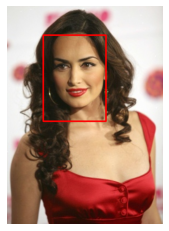

(128, 128, 5)


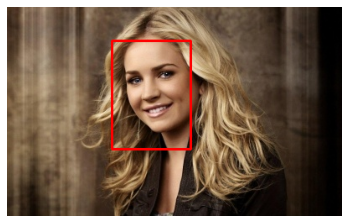

(128, 128, 5)


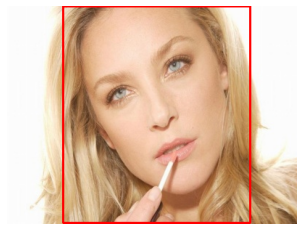

(128, 128, 5)


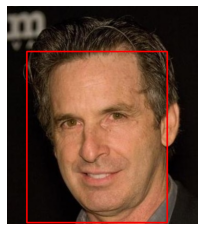

(128, 128, 5)


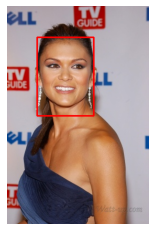

In [36]:
WINDOW_SIZE = (128, 128)
scale = 1
predictions = []
threshold_p = 0.5
overlap_threshold = 0.5
validation_data, validation_bboxes = load_validation_data(VALIDATION_FACES_DIR)
SAMPLE_IMAGES = 5
stride = 32
for img, gt_bbox in zip(validation_data[:SAMPLE_IMAGES],validation_bboxes[:SAMPLE_IMAGES]):
    #print(img.shape)
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,WINDOW_SIZE,scale,stride)
    print(patches.shape)
    
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.MiniImage, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    ## Get prediction label for each sliding window patch
    if patches_feature_representation.shape[0] > 0:
        scores = classifier.predict_proba(patches_feature_representation)
        ## Positive Face Probabilities
        face_probabilities = scores[:,1]
        face_bboxes = bbox_locations[face_probabilities>threshold_p]
        face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
        # Do non max suppression and select strongest probability box
        [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites,0.3)
    else:
        selected_bbox = []
    show_image_with_bbox(img, selected_bbox,gt_bbox)


### Evaluate Detector ###

In [38]:
total_true_positives = []
total_real_positives = []
total_positive_predictions = []
window_size = (128, 128)
validation_data, validation_bboxes = load_validation_data(VALIDATION_FACES_DIR)
k = 0
stride = 32
for img, gt_bbox in zip(validation_data,validation_bboxes):
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,scale,stride)
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.MiniImage, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    ## Get score for each sliding window patch
    scores = classifier.predict_proba(patches_feature_representation)
    ## Positive Face Probabilities
    face_probabilities = scores[:,1]
    ## liblinbear prediction
    #[labels, acc, prob] = predict([],patches_feature_representation, clasifier)
    #face_probabilities = np.asarray(prob)
    #face_probabilities = face_probabilities.T[0]

    [ detected_true_positives, image_real_positives, detected_faces ] = evaluate_detector( bbox_locations, face_probabilities, gt_bbox)
    total_true_positives.append(detected_true_positives)
    total_real_positives.append(image_real_positives)
    total_positive_predictions.append(detected_faces)
        
total_true_positives = np.asarray(total_true_positives)
total_real_positives = np.asarray(total_real_positives)
total_positive_predictions = np.asarray(total_positive_predictions)
        
        


(877, 5)


100%|████████████████████████████████████████| 877/877 [00:01<00:00, 693.54it/s]


### Evaluation Results 

In [39]:
precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_positive_predictions)

In [40]:
np.sum(total_true_positives)

1816.0

(0.0, 1.1)

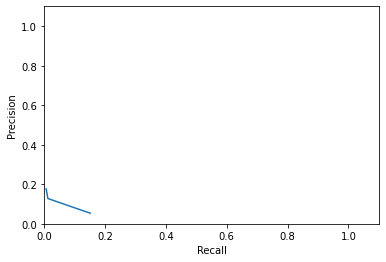

In [41]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)

In [42]:
ap = interpolated_average_precision(recall,precision)

In [43]:
print('Detection Average Precision is {}'.format(ap))

Detection Average Precision is [0.00120732]
